# 0. Importing Necessary Packages

어떻게 했는 지 모르겠는데 base python 3.7.6에서 안되던거 일단 아래 명령어로 해결 _ Kernel Restart 하고 나서 shell 명령 안되는 거 해결

In [1]:
%set_env PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin

env: PATH=/root/anaconda3/bin:/root/anaconda3/condabin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/root/.fzf./bin


In [2]:
# Printing the information of Python, IPython, OS, and the generation date.
%load_ext version_information
%version_information
%matplotlib inline

In [3]:
# Printing the versions of packages
from importlib_metadata import version
for pkg in ['numpy', 'matplotlib', 'astropy', 'pandas']:
    print(pkg+": ver "+version(pkg))

numpy: ver 1.18.1
matplotlib: ver 3.1.3
astropy: ver 4.0
pandas: ver 1.0.1


In [4]:
# matplotlib backend
%matplotlib notebook

# importing necessary modules
import numpy as np
import glob, os
from matplotlib import pyplot as plt
from astropy.io import fits
import pandas as pd
from acstools import acszpt
from reproject import reproject_interp

In [5]:
from email.utils import decode_rfc2231
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy import units as u


from scipy import stats 

In [6]:
colnames_cat = ['id', 'RA','Dec', 'x', 'y', 'fwhm', 
'area', 'stel', 'ell', 'theta', 'nf5sig', 'nfobs', 'f435w_mag', 'f435w_magerr',
'f435w_flux', 'f435w_fluxerr', 'f435w_fluxnJy', 'f435w_fluxnJyerr', 'f435w_sig', 'f606w_mag', 'f606w_magerr', 'f606w_flux', 
'f606w_fluxerr' , 'f606w_fluxnJy', 'f606w_fluxnJyerr', 'f606w_sig', 'f814w_mag', 'f814w_magerr', 'f814w_flux', 'f814w_fluxerr', 
'f814w_fluxnJy', 'f814w_fluxnJyerr' , 'f814w_sig' , 'f105w_mag', 'f105w_magerr', 'f105w_flux', 'f105w_fluxerr', 'f105w_fluxnJy', 
'f105w_fluxnJyerr', 'f105w_sig', 'f125w_mag', 'f125w_magerr', 'f125w_flux', 'f125w_fluxerr', 'f125w_fluxnJy', 'f125w_fluxnJyerr', 'f125w_sig', 
'f140w_mag', 'f140w_magerr', 'f140w_flux', 'f140w_fluxerr', 'f140w_fluxnJy', 'f140w_fluxnJyerr', 'f140w_sig', 'f160w_mag', 'f160w_magerr', 'f160w_flux',
'f160w_fluxerr', 'f160w_fluxnJy', 'f160w_fluxnJyerr', 'f160w_sig', 'bright_mag', 'bright_magerr', 'zb', 'zbmin', 'zbmax', 'tb', 'odds', 'chisq', 
'chisq2', 'M0', 'zml', 'tml'] 
colnames = ['x','y','num','mag_auto','merr_auto','mag_iso','merr_iso','mag_isocor', 'magerr_isocor','kron','backgr','ra','dec',
            'a','b','theta','mu0','flag','fwhm','flxrad','cl']

In [7]:
def galextcor(data, wavelength):
    EBV = 0.1893
    if wavelength == "F390W":
        data['mag_isocor'] = data['mag_isocor'] - (4.514 * EBV)
        return data
    elif wavelength == "F435W":
        data['mag_isocor'] = data['mag_isocor'] - (4.117 * EBV)
        return data
    elif wavelength == "F475W":
        data['mag_isocor'] = data['mag_isocor'] - (3.747 * EBV)
        return data
    elif wavelength == "F555W":
        data['mag_isocor'] = data['mag_isocor'] - (3.242 * EBV)
        return data
    elif wavelength == "F606W":
        data['mag_isocor'] = data['mag_isocor'] - (2.929 * EBV)
        return data
    elif wavelength == "F625W":
        data['mag_isocor'] = data['mag_isocor'] - (2.671 * EBV)
        return data
    elif wavelength == "F775W":
        data['mag_isocor'] = data['mag_isocor'] - (2.018 * EBV)
        return data
    elif wavelength == "F814W":
        data['mag_isocor'] = data['mag_isocor'] - (1.847 * EBV)
        return data
    elif wavelength == "F850LP":
        data['mag_isocor'] = data['mag_isocor'] - (1.473 * EBV)
        return data
    elif wavelength == "F105W":
        data['mag_isocor'] = data['mag_isocor'] - (1.015 * EBV)
        return data
    elif wavelength == "F110W":
        data['mag_isocor'] = data['mag_isocor'] - (0.876 * EBV)
        return data
    elif wavelength == "F125W":
        data['mag_isocor'] = data['mag_isocor'] - (0.757 * EBV)
        return data
    elif wavelength == "F140W":
        data['mag_isocor'] = data['mag_isocor'] - (0.609 * EBV)
        return data
    elif wavelength == "F160W":
        data['mag_isocor'] = data['mag_isocor'] - (0.470 * EBV)
        return data
    else:
        print("wrong input")

In [8]:
class matchingsexcat:
    def __init__(self, dat_sex, dat_catalog):  # def __init__(self, dat_sex, dat_catalog, tolerance)
        tol = 0.5 / 3600 # tol = tolerance / 3600
        ra_s, dec_s = dat_sex['ra'], dat_sex['dec']
        ra_c, dec_c = dat_catalog['RA'], dat_catalog['Dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from catalogs
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matchedsex(self, dat_sex):
        return dat_sex[self.idx_src]

    def matchedsex_index(self):
        return self.idx_src

    def matchedcat(self, dat_catalog):
        return dat_catalog[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch

class matchingsexsex:  # Sextractor Output 2개 끼리 서로 서로 매칭하는 코드 
    def __init__(self, dat_sex1, dat_sex2):  # def __init__(self, dat_sex1, dat_sex2, tolerance)
        tol = 0.5 / 3600 # tol = tolerance / 3600
        ra_s, dec_s = dat_sex1['ra'], dat_sex1['dec']
        ra_c, dec_c = dat_sex2['ra'], dat_sex2['dec']
        src = SkyCoord(ra=ra_s*u.degree, dec=dec_s*u.degree)    # coordinates from SExtractor
        cat = SkyCoord(ra=ra_c*u.degree, dec=dec_c*u.degree)    # coordinates from SExtractor2
        idx, sep2d, dist3d = match_coordinates_sky(src, cat, nthneighbor=1, storekdtree='kdtree_sky')    # 매칭 함수 실행

        matched = sep2d.value < tol    # 매칭 조건 적용
        self.n_mch = np.sum(matched)    # 매칭된 개수
        self.idx_cat = idx[matched]    # cat의 매칭된 인덱스
        self.idx_src = np.where(matched)[0]    # src의 매칭된 인덱스

    def matchedsex(self, dat_sex1):
        return dat_sex1[self.idx_src]

    def matchedsex_index(self):
        return self.idx_src

    def matchedcat(self, dat_sex2):
        return dat_sex2[self.idx_cat]

    def matchedcat_index(self):
        return self.idx_cat

    def matchedsize(self):
        return self.n_mch


## 1. F105W-F160W

In [9]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F160W.cat', dtype=None, encoding='ascii', names=colnames)


band = ["F105W", "F160W"]
band_catread = ["f105w", "f160w"]

# dat_0, dat_1, dat_cat = satlim(dat_0), satlim(dat_1), satlim(dat_cat)
dat_0 = galextcor(dat_0, "F105W")
dat_1 = galextcor(dat_1, "F160W")

F105WF160W_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
F105WF160W_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
F105WF160W_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

(30, 15)

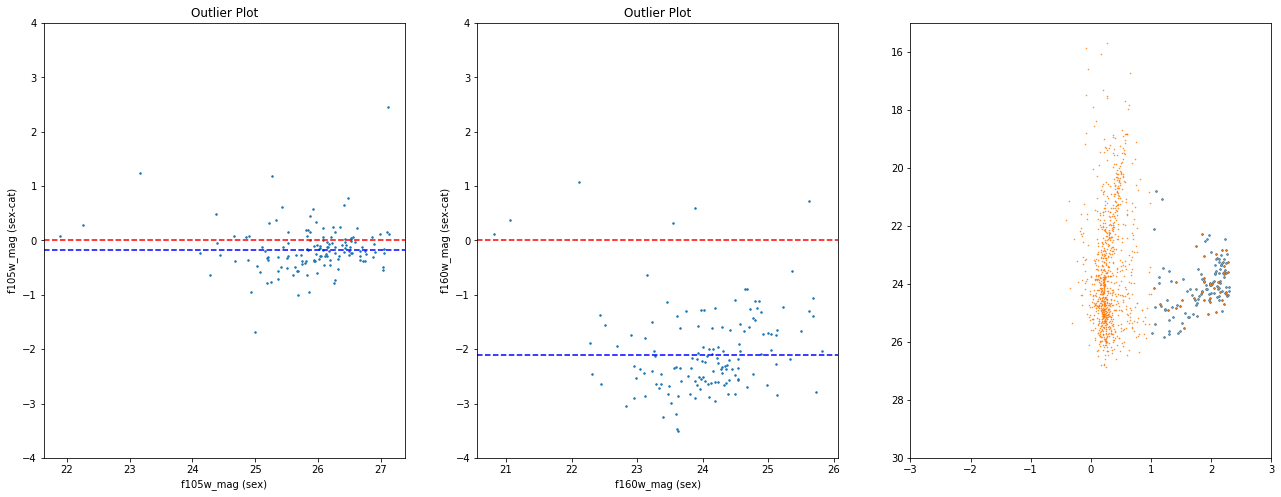

In [10]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(22,8))

stelf_sex = F105WF160W_F105W['mag_isocor'] - F105WF160W_F160W['mag_isocor'] > 1
ax[0].plot(F105WF160W_F105W[stelf_sex]['mag_isocor'], F105WF160W_F105W[stelf_sex]['mag_isocor'] - F105WF160W_Cat[stelf_sex]['f105w_mag'], 'o', ms=1.5)
ax[0].set_xlabel('f105w_mag (sex)')
ax[0].set_ylabel('f105w_mag (sex-cat)')
ax[0].set_title('Outlier Plot')
ax[0].axhline(0, ls='--', color='red')
ax[0].axhline(stats.trim_mean(F105WF160W_F105W[stelf_sex]['mag_isocor'] - F105WF160W_Cat[stelf_sex]['f105w_mag'], 0.05), ls='--', color='blue')
ax[0].set_ylim(-4, 4)

ax[1].plot(F105WF160W_F160W[stelf_sex]['mag_isocor'], F105WF160W_F160W[stelf_sex]['mag_isocor'] - F105WF160W_Cat[stelf_sex]['f160w_mag'], 'o', ms=1.5)
ax[1].set_xlabel('f160w_mag (sex)')
ax[1].set_ylabel('f160w_mag (sex-cat)')
ax[1].set_title('Outlier Plot')
ax[1].set_ylim(-4, 4)
ax[1].axhline(0, ls='--', color='red')
ax[1].axhline(stats.trim_mean(F105WF160W_F160W[stelf_sex]['mag_isocor'] - F105WF160W_Cat[stelf_sex]['f160w_mag'], 0.05), ls='--', color='blue')

ax[2].plot(F105WF160W_F105W[stelf_sex]['mag_isocor']-F105WF160W_F160W[stelf_sex]['mag_isocor'], F105WF160W_F160W[stelf_sex]['mag_isocor'], 'o', ms=1.5)
ax[2].plot(F105WF160W_F105W['mag_isocor']-F105WF160W_F160W['mag_isocor'], F105WF160W_F160W['mag_isocor'], 'o', ms=0.5)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([30, 15])


(30, 15)

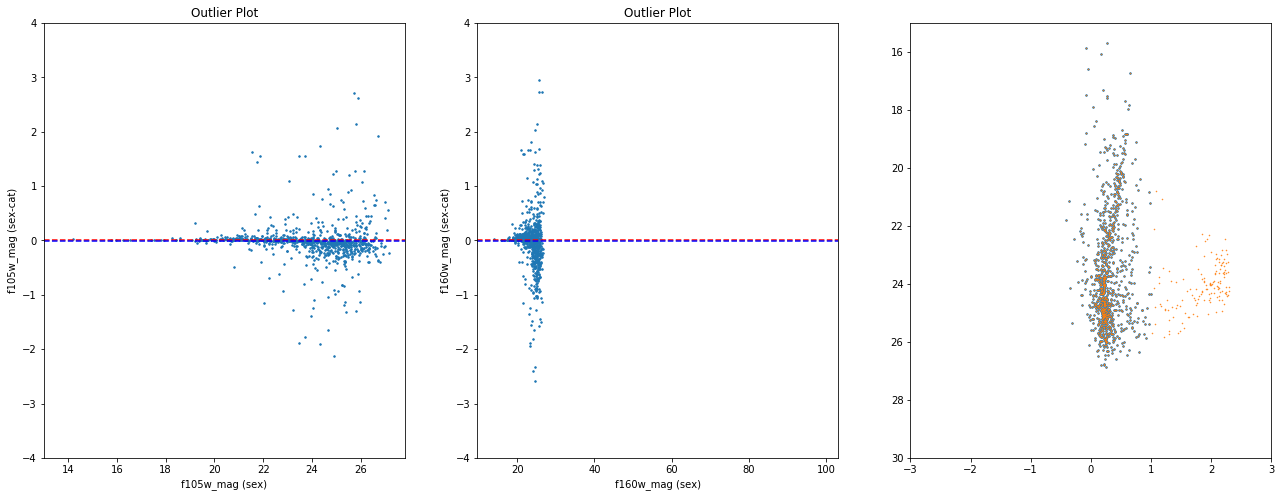

In [21]:
%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(22,8))

stelf_center = F105WF160W_F105W['mag_isocor'] - F105WF160W_F160W['mag_isocor'] < 1
ax[0].plot(F105WF160W_F105W[stelf_center]['mag_isocor'], F105WF160W_F105W[stelf_center]['mag_isocor'] - F105WF160W_Cat[stelf_center]['f105w_mag'], 'o', ms=1.5)
ax[0].set_xlabel('f105w_mag (sex)')
ax[0].set_ylabel('f105w_mag (sex-cat)')
ax[0].set_title('Outlier Plot')
ax[0].axhline(0, ls='--', color='red')
ax[0].axhline(stats.trim_mean(F105WF160W_F105W[stelf_center]['mag_isocor'] - F105WF160W_Cat[stelf_center]['f105w_mag'], 0.05), ls='--', color='blue')
ax[0].set_ylim(-4, 4)

ax[1].plot(F105WF160W_F160W[stelf_center]['mag_isocor'], F105WF160W_F160W[stelf_center]['mag_isocor'] - F105WF160W_Cat[stelf_center]['f160w_mag'], 'o', ms=1.5)
ax[1].set_xlabel('f160w_mag (sex)')
ax[1].set_ylabel('f160w_mag (sex-cat)')
ax[1].set_title('Outlier Plot')
ax[1].set_ylim(-4, 4)
ax[1].axhline(0, ls='--', color='red')
ax[1].axhline(stats.trim_mean(F105WF160W_F160W[stelf_center]['mag_isocor'] - F105WF160W_Cat[stelf_center]['f160w_mag'], 0.05), ls='--', color='blue')

ax[2].plot(F105WF160W_F105W[stelf_center]['mag_isocor']-F105WF160W_F160W[stelf_center]['mag_isocor'], F105WF160W_F160W[stelf_center]['mag_isocor'], 'o', ms=1.5)
ax[2].plot(F105WF160W_F105W['mag_isocor']-F105WF160W_F160W['mag_isocor'], F105WF160W_F160W['mag_isocor'], 'o', ms=0.5)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([30, 15])




## 2. F125W-F160W

(30, 15)

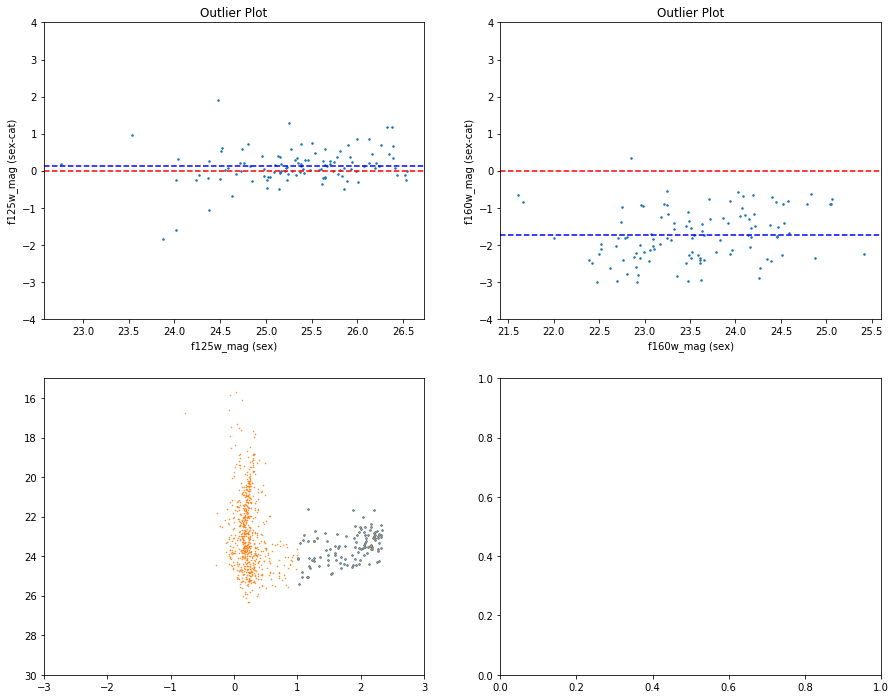

In [11]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F125W-F160W/F125W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F125W-F160W/F160W.cat', dtype=None, encoding='ascii', names=colnames)

band = ["F125W", "F160W"]
band_catread = ["f125w", "f160w"]

dat_0 = galextcor(dat_0, "F125W")
dat_1 = galextcor(dat_1, "F160W")

F125WF160W_F125W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
F125WF160W_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
F125WF160W_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(15,12))

stelf_sex = F125WF160W_F125W['mag_isocor'] - F125WF160W_F160W['mag_isocor'] > 1

ax[0,0].plot(F125WF160W_F125W[stelf_sex]['mag_isocor'], F125WF160W_F125W[stelf_sex]['mag_isocor'] - F125WF160W_Cat[stelf_sex]['f125w_mag'], 'o', ms=1.5)
ax[0,0].set_xlabel('f125w_mag (sex)')
ax[0,0].set_ylabel('f125w_mag (sex-cat)')
ax[0,0].set_title('Outlier Plot')
ax[0,0].axhline(0, ls='--', color='red')
ax[0,0].axhline(stats.trim_mean(F125WF160W_F125W[stelf_sex]['mag_isocor'] - F125WF160W_Cat[stelf_sex]['f125w_mag'], 0.05), ls='--', color='blue')
ax[0,0].set_ylim(-4, 4)

ax[0,1].plot(F125WF160W_F160W[stelf_sex]['mag_isocor'], F125WF160W_F160W[stelf_sex]['mag_isocor'] - F125WF160W_Cat[stelf_sex]['f160w_mag'], 'o', ms=1.5)
ax[0,1].set_xlabel('f160w_mag (sex)')
ax[0,1].set_ylabel('f160w_mag (sex-cat)')
ax[0,1].set_title('Outlier Plot')
ax[0,1].set_ylim(-4, 4)
ax[0,1].axhline(0, ls='--', color='red')
ax[0,1].axhline(stats.trim_mean(F125WF160W_F160W[stelf_sex]['mag_isocor'] - F125WF160W_Cat[stelf_sex]['f160w_mag'], 0.05), ls='--', color='blue')

ax[1,0].plot(F125WF160W_F125W[stelf_sex]['mag_isocor']-F125WF160W_F160W[stelf_sex]['mag_isocor'], F125WF160W_F160W[stelf_sex]['mag_isocor'], 'o', ms=1.5)
ax[1,0].plot(F125WF160W_F125W['mag_isocor']-F125WF160W_F160W['mag_isocor'], F125WF160W_F160W['mag_isocor'], 'o', ms=0.5)
ax[1,0].set_xlim([-3, 3])
ax[1,0].set_ylim([30, 15])



## 3. F125W-F140W

(30, 15)

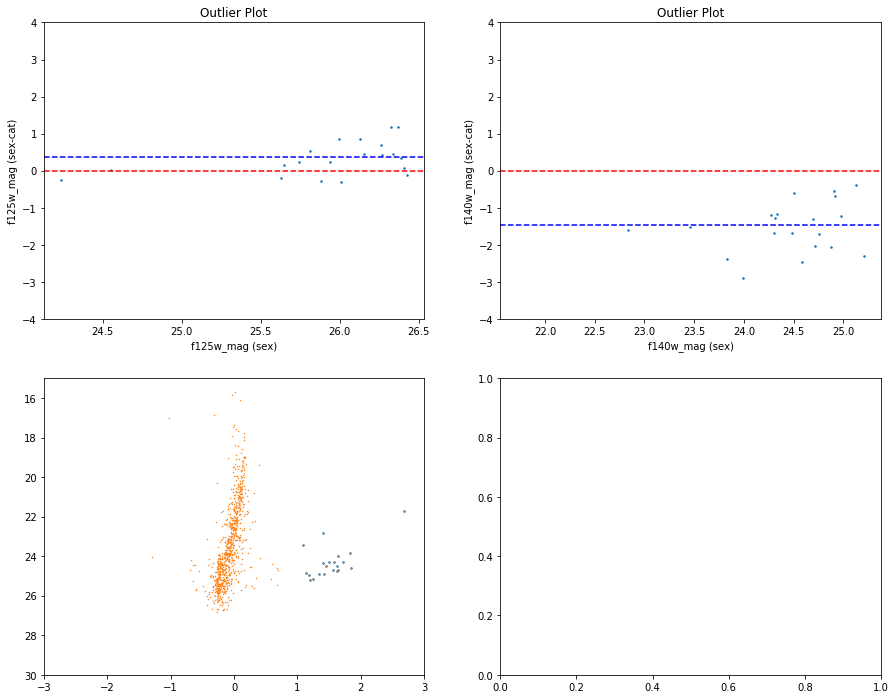

In [12]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F125W-F140W/F125W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F125W-F140W/F140W.cat', dtype=None, encoding='ascii', names=colnames)

band = ["F125W", "F140W"]
band_catread = ["f125w", "f140w"]

dat_0 = galextcor(dat_0, "F125W")
dat_1 = galextcor(dat_1, "F140W")

F125WF140W_F125W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
F125WF140W_F140W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
F125WF140W_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(15,12))

stelf_sex = F125WF140W_F125W['mag_isocor'] - F125WF140W_F140W['mag_isocor'] > 1

ax[0,0].plot(F125WF140W_F125W[stelf_sex]['mag_isocor'], F125WF140W_F125W[stelf_sex]['mag_isocor'] - F125WF140W_Cat[stelf_sex]['f125w_mag'], 'o', ms=1.5)
ax[0,0].set_xlabel('f125w_mag (sex)')
ax[0,0].set_ylabel('f125w_mag (sex-cat)')
ax[0,0].set_title('Outlier Plot')
ax[0,0].axhline(0, ls='--', color='red')
ax[0,0].axhline(stats.trim_mean(F125WF140W_F125W[stelf_sex]['mag_isocor'] - F125WF140W_Cat[stelf_sex]['f125w_mag'], 0.05), ls='--', color='blue')
ax[0,0].set_ylim(-4, 4)

ax[0,1].plot(F125WF140W_F140W[stelf_sex]['mag_isocor'], F125WF140W_F140W[stelf_sex]['mag_isocor'] - F125WF140W_Cat[stelf_sex]['f140w_mag'], 'o', ms=1.5)
ax[0,1].set_xlabel('f140w_mag (sex)')
ax[0,1].set_ylabel('f140w_mag (sex-cat)')
ax[0,1].set_title('Outlier Plot')
ax[0,1].set_ylim(-4, 4)
ax[0,1].axhline(0, ls='--', color='red')
ax[0,1].axhline(stats.trim_mean(F125WF140W_F140W[stelf_sex]['mag_isocor'] - F125WF140W_Cat[stelf_sex]['f140w_mag'], 0.05), ls='--', color='blue')

ax[1,0].plot(F125WF140W_F125W[stelf_sex]['mag_isocor']-F125WF140W_F140W[stelf_sex]['mag_isocor'], F125WF140W_F140W[stelf_sex]['mag_isocor'], 'o', ms=1.5)
ax[1,0].plot(F125WF140W_F125W['mag_isocor']-F125WF140W_F140W['mag_isocor'], F125WF140W_F140W['mag_isocor'], 'o', ms=0.5)
ax[1,0].set_xlim([-3, 3])
ax[1,0].set_ylim([30, 15])



## 4. F105W-F140W

(30, 15)

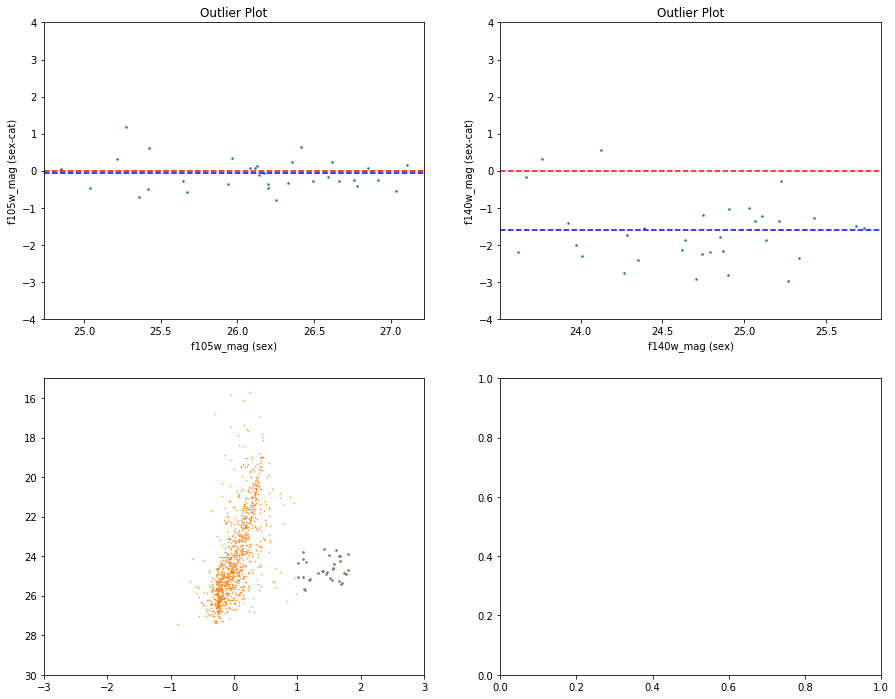

In [13]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F140W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F140W/F140W.cat', dtype=None, encoding='ascii', names=colnames)

band = ["F105W", "F140W"]
band_catread = ["f105w", "f140w"]

dat_0 = galextcor(dat_0, "F105W")
dat_1 = galextcor(dat_1, "F140W")

F105WF140W_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
F105WF140W_F140W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
F105WF140W_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize=(15,12))

stelf_sex = F105WF140W_F105W['mag_isocor'] - F105WF140W_F140W['mag_isocor'] > 1

ax[0,0].plot(F105WF140W_F105W[stelf_sex]['mag_isocor'], F105WF140W_F105W[stelf_sex]['mag_isocor'] - F105WF140W_Cat[stelf_sex]['f105w_mag'], 'o', ms=1.5)
ax[0,0].set_xlabel('f105w_mag (sex)')
ax[0,0].set_ylabel('f105w_mag (sex-cat)')
ax[0,0].set_title('Outlier Plot')
ax[0,0].axhline(0, ls='--', color='red')
ax[0,0].axhline(stats.trim_mean(F105WF140W_F105W[stelf_sex]['mag_isocor'] - F105WF140W_Cat[stelf_sex]['f105w_mag'], 0.05), ls='--', color='blue')
ax[0,0].set_ylim(-4, 4)

ax[0,1].plot(F105WF140W_F140W[stelf_sex]['mag_isocor'], F105WF140W_F140W[stelf_sex]['mag_isocor'] - F105WF140W_Cat[stelf_sex]['f140w_mag'], 'o', ms=1.5)
ax[0,1].set_xlabel('f140w_mag (sex)')
ax[0,1].set_ylabel('f140w_mag (sex-cat)')
ax[0,1].set_title('Outlier Plot')
ax[0,1].set_ylim(-4, 4)
ax[0,1].axhline(0, ls='--', color='red')
ax[0,1].axhline(stats.trim_mean(F105WF140W_F140W[stelf_sex]['mag_isocor'] - F105WF140W_Cat[stelf_sex]['f140w_mag'], 0.05), ls='--', color='blue')

ax[1,0].plot(F105WF140W_F105W[stelf_sex]['mag_isocor']-F105WF140W_F140W[stelf_sex]['mag_isocor'], F105WF140W_F140W[stelf_sex]['mag_isocor'], 'o', ms=1.5)
ax[1,0].plot(F105WF140W_F105W['mag_isocor']-F105WF140W_F140W['mag_isocor'], F105WF140W_F140W['mag_isocor'], 'o', ms=0.5)
ax[1,0].set_xlim([-3, 3])
ax[1,0].set_ylim([30, 15])



## 5. F105W-F160W (refimg changed to F160W )   (F160W-F105W 라고 표기) 

(30, 15)

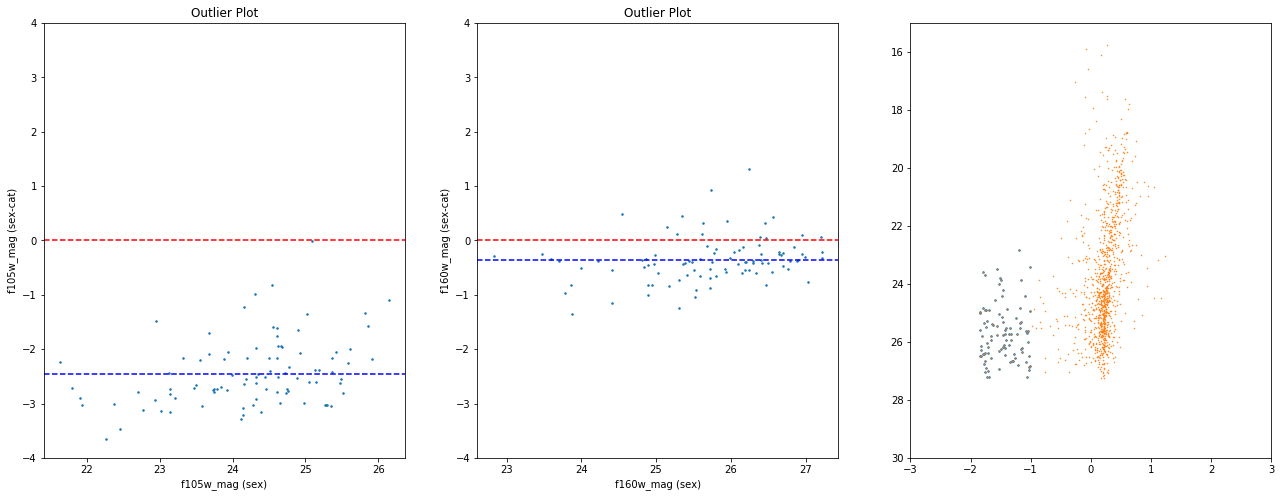

In [14]:
dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)
dat_0 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_1 = np.genfromtxt('/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F160W.cat', dtype=None, encoding='ascii', names=colnames)

band = ["F105W", "F160W"]
band_catread = ["f105w", "f160w"]

dat_0 = galextcor(dat_0, "F105W")
dat_1 = galextcor(dat_1, "F160W")

F160WF105W_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0)
F160WF105W_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1)
F160WF105W_Cat = matchingsexcat(dat_0, dat_cat).matchedcat(dat_cat)

%matplotlib inline
fig, ax = plt.subplots(1, 3, figsize=(22,8))

stelf_sex = F160WF105W_F105W['mag_isocor'] - F160WF105W_F160W['mag_isocor'] < -1

ax[0].plot(F160WF105W_F105W[stelf_sex]['mag_isocor'], F160WF105W_F105W[stelf_sex]['mag_isocor'] - F160WF105W_Cat[stelf_sex]['f105w_mag'], 'o', ms=1.5)
ax[0].set_xlabel('f105w_mag (sex)')
ax[0].set_ylabel('f105w_mag (sex-cat)')
ax[0].set_title('Outlier Plot')
ax[0].axhline(0, ls='--', color='red')
ax[0].axhline(stats.trim_mean(F160WF105W_F105W[stelf_sex]['mag_isocor'] - F160WF105W_Cat[stelf_sex]['f105w_mag'], 0.05), ls='--', color='blue')
ax[0].set_ylim(-4, 4)

ax[1].plot(F160WF105W_F160W[stelf_sex]['mag_isocor'], F160WF105W_F160W[stelf_sex]['mag_isocor'] - F160WF105W_Cat[stelf_sex]['f160w_mag'], 'o', ms=1.5)
ax[1].set_xlabel('f160w_mag (sex)')
ax[1].set_ylabel('f160w_mag (sex-cat)')
ax[1].set_title('Outlier Plot')
ax[1].set_ylim(-4, 4)
ax[1].axhline(0, ls='--', color='red')
ax[1].axhline(stats.trim_mean(F160WF105W_F160W[stelf_sex]['mag_isocor'] - F160WF105W_Cat[stelf_sex]['f160w_mag'], 0.05), ls='--', color='blue')

ax[2].plot(F160WF105W_F105W[stelf_sex]['mag_isocor']-F160WF105W_F160W[stelf_sex]['mag_isocor'], F160WF105W_F160W[stelf_sex]['mag_isocor'], 'o', ms=1.5)
ax[2].plot(F160WF105W_F105W['mag_isocor']-F160WF105W_F160W['mag_isocor'], F160WF105W_F160W['mag_isocor'], 'o', ms=0.5)
ax[2].set_xlim([-3, 3])
ax[2].set_ylim([30, 15])



# Difference of 105160 refimg 

In [15]:
dat_a = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F160W.cat', dtype=None, encoding='ascii', names=colnames)
dat_a_sub = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F105W.cat', dtype=None, encoding='ascii', names=colnames)

dat_b = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_b_sub = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F160W.cat', dtype=None, encoding='ascii', names=colnames)

dat_cat = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)


# F105WF160W_F105W = matchingsexcat(dat_0, dat_cat).matchedsex(dat_0) dat_a_sub
# F160WF105W_F160W = matchingsexcat(dat_1, dat_cat).matchedsex(dat_1) dat_b_sub


stelf_sex1 = F105WF160W_F105W['mag_isocor'] - F105WF160W_F160W['mag_isocor'] > 1
stelf_sex2 = F160WF105W_F105W['mag_isocor'] - F160WF105W_F160W['mag_isocor'] < -1

ref1 = matchingsexcat(dat_a_sub, dat_cat).matchedsex(dat_a_sub)[stelf_sex1] # F105WF160W_F105W['mag_isocor'] 중 outlier 
ref2 = matchingsexcat(dat_b, dat_cat).matchedsex(dat_b)[stelf_sex2] # F160WF105W_F160W['mag_isocor'] 중 outlier 

switch11 = matchingsexsex(ref1, dat_b).matchedcat(dat_b) # --> 여기서 F105W 뽑고 
switch12 = matchingsexsex(ref1, dat_b_sub).matchedcat(dat_b_sub) # --> 여기서 F160W 뽑고 


switch21 = matchingsexsex(ref2, dat_a).matchedcat(dat_a) #--> 여기서 160W 
switch22 = matchingsexsex(ref2, dat_a_sub).matchedcat(dat_a_sub) # ---> 여기서 105W 

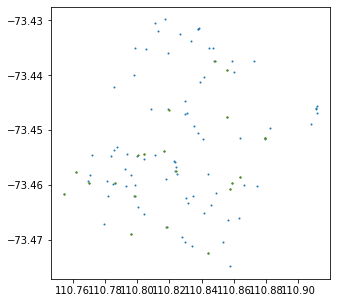

In [16]:
figs, axes = plt.subplots(1, 1, figsize = (5, 5))
axes.plot(ref2['ra'], ref2['dec'], 'o', ms=1)
axes.plot(switch22['ra'], switch22['dec'], 'o', ms=1)
axes.plot(switch21['ra'], switch21['dec'], 'o', ms=1)


## CMD 로 Outlier 양쪽상의 위치 그리기 

Text(0.5, 0, 'f105w_mag-f160w_mag')

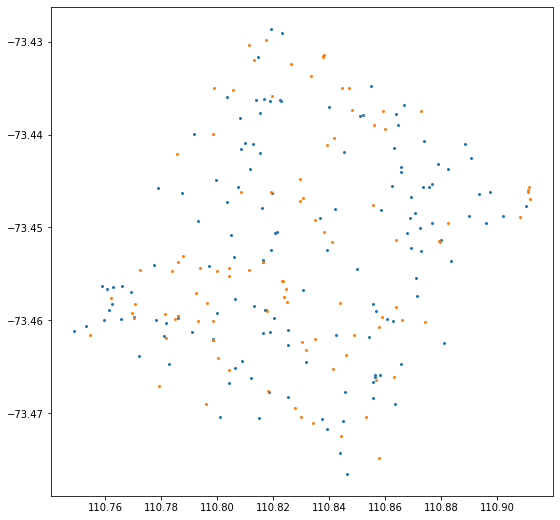

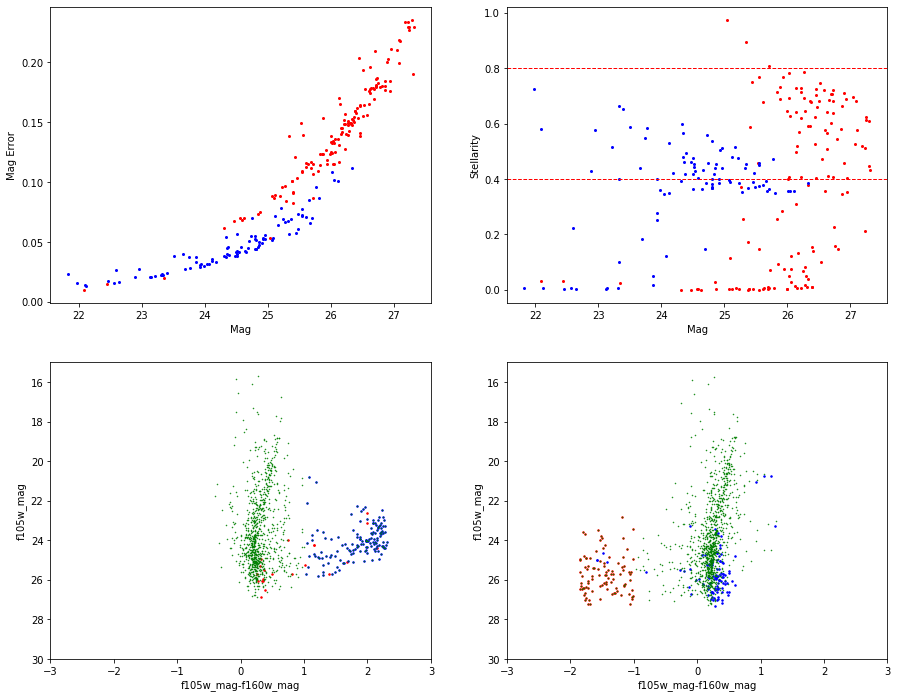

In [17]:
figs, axes = plt.subplots(1, 1, figsize = (9, 9))
axes.plot(ref1['ra'], ref1['dec'], 'o', ms=2)
axes.plot(ref2['ra'], ref2['dec'], 'o', ms=2)


fig, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0,0].plot(ref1['mag_isocor'], ref1['magerr_isocor'], 'o', ms=2, color = 'red')
ax[0,0].plot(ref2['mag_isocor'], ref2['magerr_isocor'], 'o', ms=2, color = 'blue')
ax[0,0].set_xlabel('Mag')
ax[0,0].set_ylabel('Mag Error')


ax[0,1].plot(ref1['mag_isocor'], ref1['cl'], 'o', ms=2, color='red')
ax[0,1].plot(ref2['mag_isocor'], ref2['cl'], 'o', ms=2, color='blue')
ax[0,1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0,1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)
ax[0,1].set_xlabel('Mag')
ax[0,1].set_ylabel('Stellarity')


#CMD 상에서 위치 그리기 ! 

# ax[1,0].plot(ref1['mag_isocor']-ref2['mag_isocor'], ref2['mag_isocor'], 'o', ms=1.5)

ax[1,0].plot(switch22['mag_isocor']-switch21['mag_isocor'], switch21['mag_isocor'], 'o', ms=1.5, color = 'red')
ax[1,0].plot(F105WF160W_F105W[stelf_sex1]['mag_isocor']-F105WF160W_F160W[stelf_sex1]['mag_isocor'], F105WF160W_F160W[stelf_sex1]['mag_isocor'], 'o', ms=1.5, color = 'blue')
ax[1,0].plot(F105WF160W_F105W['mag_isocor']-F105WF160W_F160W['mag_isocor'], F105WF160W_F160W['mag_isocor'], 'o', ms=0.5, color = 'green')
ax[1,0].set_xlim([-3, 3])
ax[1,0].set_ylim([30, 15])
ax[1,0].set_ylabel('f105w_mag')
ax[1,0].set_xlabel('f105w_mag-f160w_mag')

ax[1,1].plot(switch11['mag_isocor']-switch12['mag_isocor'], switch12['mag_isocor'], 'o', ms=1.5, color = 'blue')
ax[1,1].plot(F160WF105W_F105W[stelf_sex2]['mag_isocor']-F160WF105W_F160W[stelf_sex2]['mag_isocor'], F160WF105W_F160W[stelf_sex2]['mag_isocor'], 'o', ms=1.5, color = 'red')
ax[1,1].plot(F160WF105W_F105W['mag_isocor']-F160WF105W_F160W['mag_isocor'], F160WF105W_F160W['mag_isocor'], 'o', ms=0.5, color = 'green')


ax[1,1].set_xlim([-3, 3])
ax[1,1].set_ylim([30, 15])
ax[1,1].set_ylabel('f105w_mag')
ax[1,1].set_xlabel('f105w_mag-f160w_mag')

# change legend markersize
# lgnd = ax[0,0].legend()
# lgnd.legendHandles[0]._legmarker.set_markersize(6)
# lgnd.legendHandles[1]._legmarker.set_markersize(6)

red 점들은 별로 매칭이 잘 안되었다. blue 친구들도 매칭이 잘 안되고 ... 아마 둘다 동시에 Detect 되지 않는 듯 하다. 

In [18]:
# test.reg 만드는 코드 

f = open('test2.reg', 'w')

src1 = [ref1['x'], ref1['y']]     
src1 = np.transpose(src1)
src1 = pd.DataFrame(src1, columns=['x', 'y'])
src2 = [ref2['x'], ref2['y']]     
src2 = np.transpose(src2)
src2 = pd.DataFrame(src2, columns=['x', 'y'])

for i in np.arange(len(src1)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src1['x'][i], src1['y'][i]))
    # 이미지에서 source의 x, y 좌표를 중심으로 한 20 pixel 반경의 원을 display하여 보여주는 region file 쓰기

for i in np.arange(len(src2)):
    f.write('image;circle(%.2f, %.2f, 20) \n' %(src2['x'][i], src2['y'][i]))
    
f.close()

### 디스플레이 방법: DS9 - Region - Load regions - 'test.reg' 열기



F105-F160 / F160-F105 둘다 Detect 되는 친구들만 놓기 

In [19]:
dat_alpha160 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F160W.cat', dtype=None, encoding='ascii', names=colnames)
dat_alpha105 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F105W-F160W/F105W.cat', dtype=None, encoding='ascii', names=colnames)

dat_beta105 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F105W.cat', dtype=None, encoding='ascii', names=colnames)
dat_beta160 = np.genfromtxt( '/data/jip/1st_TASK_Relics_SMACS/Analysis-Result/60mas/F160W-F105W/F160W.cat', dtype=None, encoding='ascii', names=colnames)

dat_cata = np.genfromtxt('../1st_TASK_Relics_SMACS/catalog/hlsp_relics_hst_wfc3ir_smacs0723-73_multi_v1_cat.txt', dtype=None, encoding='ascii', names=colnames_cat)

filteringdual_105 = matchingsexsex(dat_alpha105, dat_beta105).matchedsex(dat_alpha105) 
filteringdual_160 = matchingsexsex(dat_alpha160, dat_beta160).matchedsex(dat_alpha160) 

fff_105 = matchingsexcat(filteringdual_105, dat_cat).matchedsex(filteringdual_105)
fff_160 = matchingsexcat(filteringdual_160, dat_cat).matchedsex(filteringdual_160)
fff_cat = matchingsexcat(filteringdual_105, dat_cat).matchedcat(dat_cat)


outlier = fff_105['mag_isocor']-fff_160['mag_isocor']>1
fff_ouliermatched_cat = matchingsexcat(fff_105[outlier], dat_cat).matchedcat(dat_cat)



(30, 15)

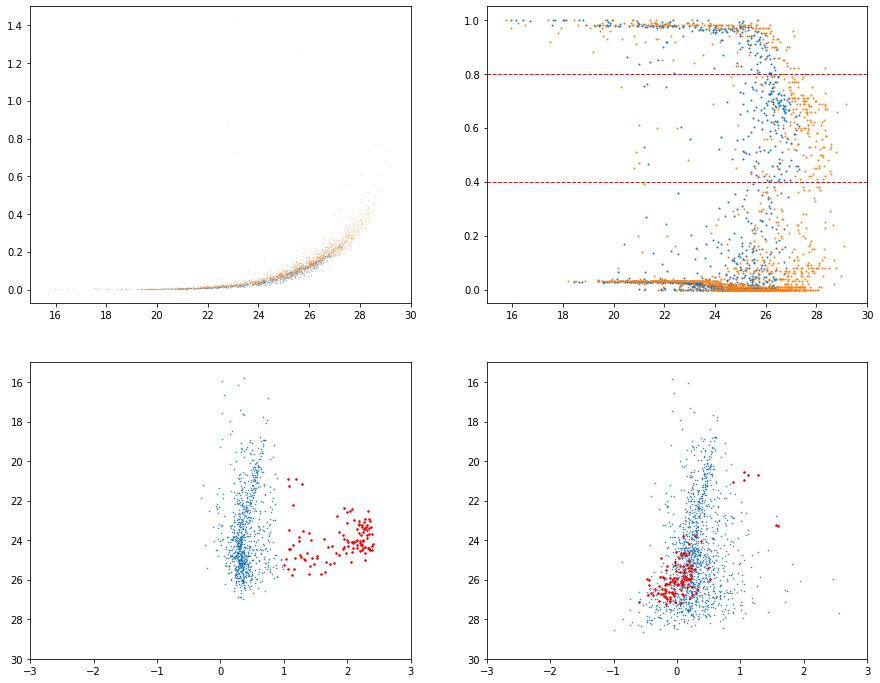

In [20]:
fig, ax = plt.subplots(2, 2, figsize=(15,12))

ax[0,0].plot(fff_105['mag_isocor'], fff_105['magerr_isocor'], 'o', ms=0.1)
ax[0,0].plot(dat_cata['f105w_mag'], dat_cata['f105w_magerr'], 'o', ms=0.1)
ax[0,0].set_xlim([15, 30])



ax[0,1].plot(fff_105['mag_isocor'], fff_105['cl'], 'o', ms=1)
ax[0,1].plot(dat_cata['f105w_mag'], dat_cata['stel'], 'o', ms=1)
ax[0,1].axhline(0.4, 0, 1, color='red', ls='--', lw=1)
ax[0,1].axhline(0.8, 0, 1, color='red', ls='--', lw=1)
ax[0,1].set_xlim([15, 30])


ax[1,0].plot(fff_105['mag_isocor']-fff_160['mag_isocor'], fff_160['mag_isocor'], 'o', ms=0.5)
ax[1,0].plot(fff_105[outlier]['mag_isocor']-fff_160[outlier]['mag_isocor'], fff_160[outlier]['mag_isocor'], 'o', ms=1.5, color = 'red')

ax[1,0].set_xlim([-3, 3])
ax[1,0].set_ylim([30, 15])

ax[1,1].plot(dat_cat['f105w_mag']-dat_cat['f160w_mag'], dat_cat['f160w_mag'], 'o', ms=0.5)
ax[1,1].plot(fff_ouliermatched_cat['f105w_mag']-fff_ouliermatched_cat['f160w_mag'], fff_ouliermatched_cat['f160w_mag'], 'o', ms=1.5, color = 'red')

ax[1,1].set_xlim([-3, 3])
ax[1,1].set_ylim([30, 15])